## 1. Preliminary

### 1.1 Libraries

In [1]:
%run Preliminary.ipynb

### 1.2 Data

In [2]:
# Load and explore the data
dt = pd.read_csv("billets.csv", sep=";", decimal=",")
banknotes = dt.copy()

We have six pieces of information on a banknote:
- length: the length of the banknote
- height_left: the height of the banknote (left)
- height_right: the height of the banknote (right)
- margin_up: the margin of the upper edge of the banknote
- margin_low: the margin of the lower edge of the banknote
- diagonal: the diagonal of the banknote

These data contain information on 1500 banknotes.

## 2. Data Preparation

In [3]:
print("Number of banknotes:", banknotes.shape[0])
print("Number of duplicate banknotes:", banknotes.duplicated().sum())
print("Number of genuine banknotes:", banknotes["is_genuine"].sum())
print("Number of counterfeit banknotes:", (banknotes["is_genuine"] == 0).sum())

Number of banknotes: 1500
Number of duplicate banknotes: 0
Number of genuine banknotes: 1000
Number of counterfeit banknotes: 500


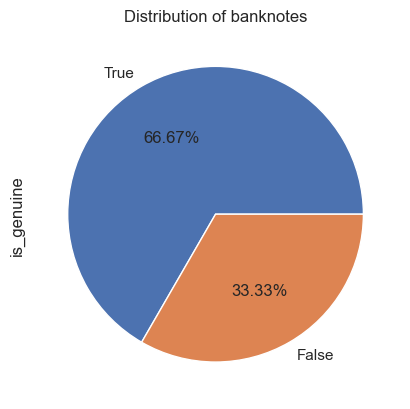

In [4]:
# Pie chart showing the distribution of banknotes
banknotes["is_genuine"].value_counts().plot.pie(autopct="%1.2f%%")
plt.title("Distribution of banknotes")
plt.show()

In [5]:
# Data Dimension
banknotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_genuine    1500 non-null   bool  
 1   diagonal      1500 non-null   object
 2   height_left   1500 non-null   object
 3   height_right  1500 non-null   object
 4   margin_low    1463 non-null   object
 5   margin_up     1500 non-null   object
 6   length        1500 non-null   object
dtypes: bool(1), object(6)
memory usage: 71.9+ KB


In [6]:
# Convert 'is_genuine' values to binary
banknotes["is_genuine"] = banknotes["is_genuine"].astype(int)

In [7]:
# Convert remaining variables to float
cols_to_convert = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
banknotes[cols_to_convert] = banknotes[cols_to_convert].astype(float)

In [8]:
# Descriptive statistics
genuine_stats = banknotes[banknotes["is_genuine"] == 1].describe()
counterfeit_stats = banknotes[banknotes["is_genuine"] == 0].describe()

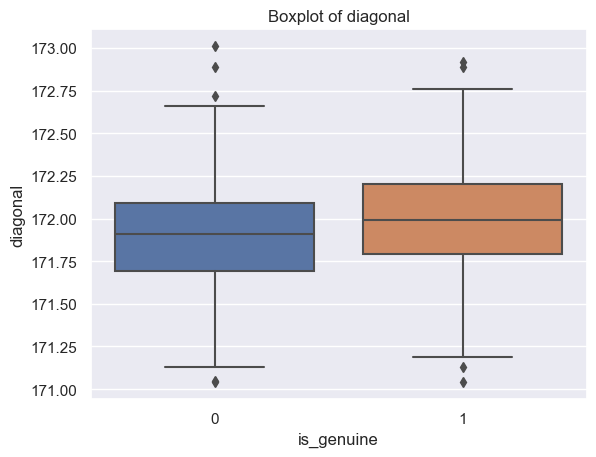

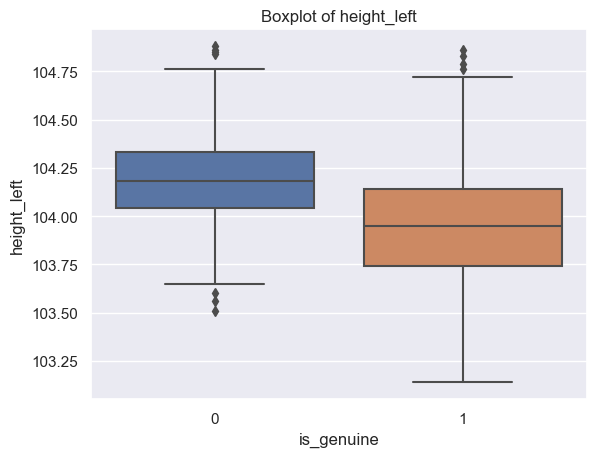

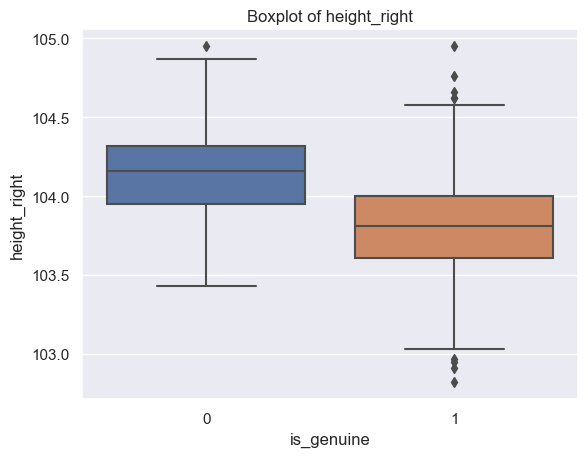

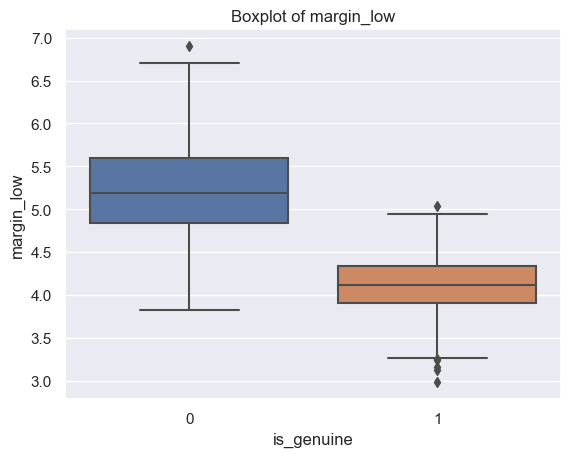

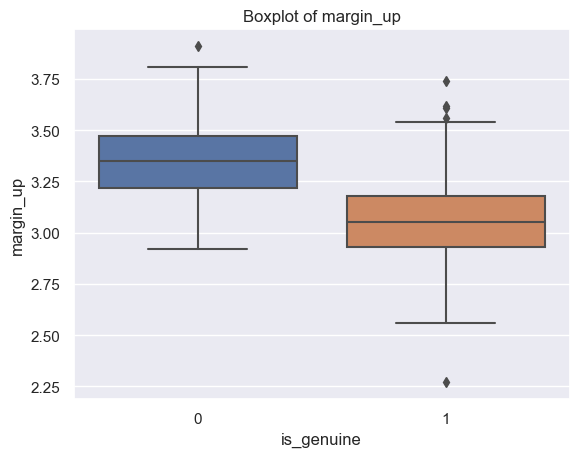

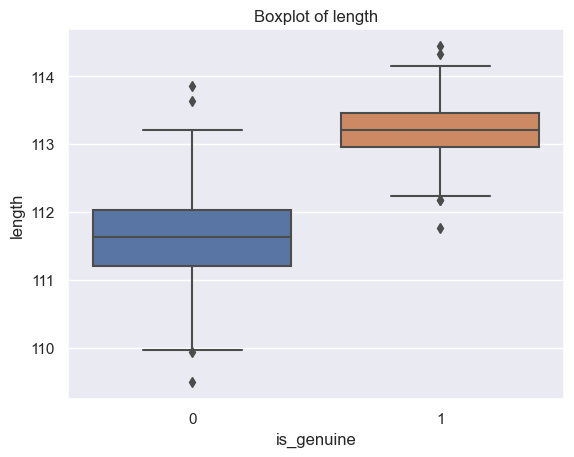

In [9]:
# Boxplots
for col in cols_to_convert:
    sns.boxplot(x="is_genuine", y=col, data=banknotes)
    plt.title(f"Boxplot of {col}")
    plt.show()

In [10]:
# Percentage differences
diff_means = ((genuine_stats - counterfeit_stats) / genuine_stats) * 100
print("Percentage Differences Between Genuine and Counterfeit Banknotes:")
display(diff_means)

Percentage Differences Between Genuine and Counterfeit Banknotes:


is_genuine   diagonal  height_left  height_right  margin_low  \
count        50.0  50.000000    50.000000     50.000000   49.330587   
mean        100.0   0.049957    -0.232046     -0.322680  -26.720415   
std           NaN  -2.136950    25.471184      7.096812  -73.453370   
min         100.0   0.000000    -0.358736     -0.593270  -28.187919   
25%         100.0   0.058211    -0.289184     -0.328154  -23.943662   
50%         100.0   0.046514    -0.221260     -0.337154  -26.277372   
75%         100.0   0.062427    -0.184847     -0.307692  -28.859447   
max         100.0  -0.052047    -0.019073      0.000000  -36.904762   

       margin_up     length  
count  50.000000  50.000000  
mean   -9.764656   1.388477  
std     3.134968 -71.197325  
min   -28.634361   2.031138  
25%    -9.897611   1.549358  
50%    -9.836066   1.391281  
75%    -9.198113   1.260356  
max    -4.545455   0.515554

- Genuine banknotes have a larger diagonal.
- Counterfeit banknotes have greater height and margins.
- Counterfeit banknotes are smaller than genuine banknotes.

In [11]:
# Data Normalization
data = data_scaler(banknotes, columns=cols_to_convert)

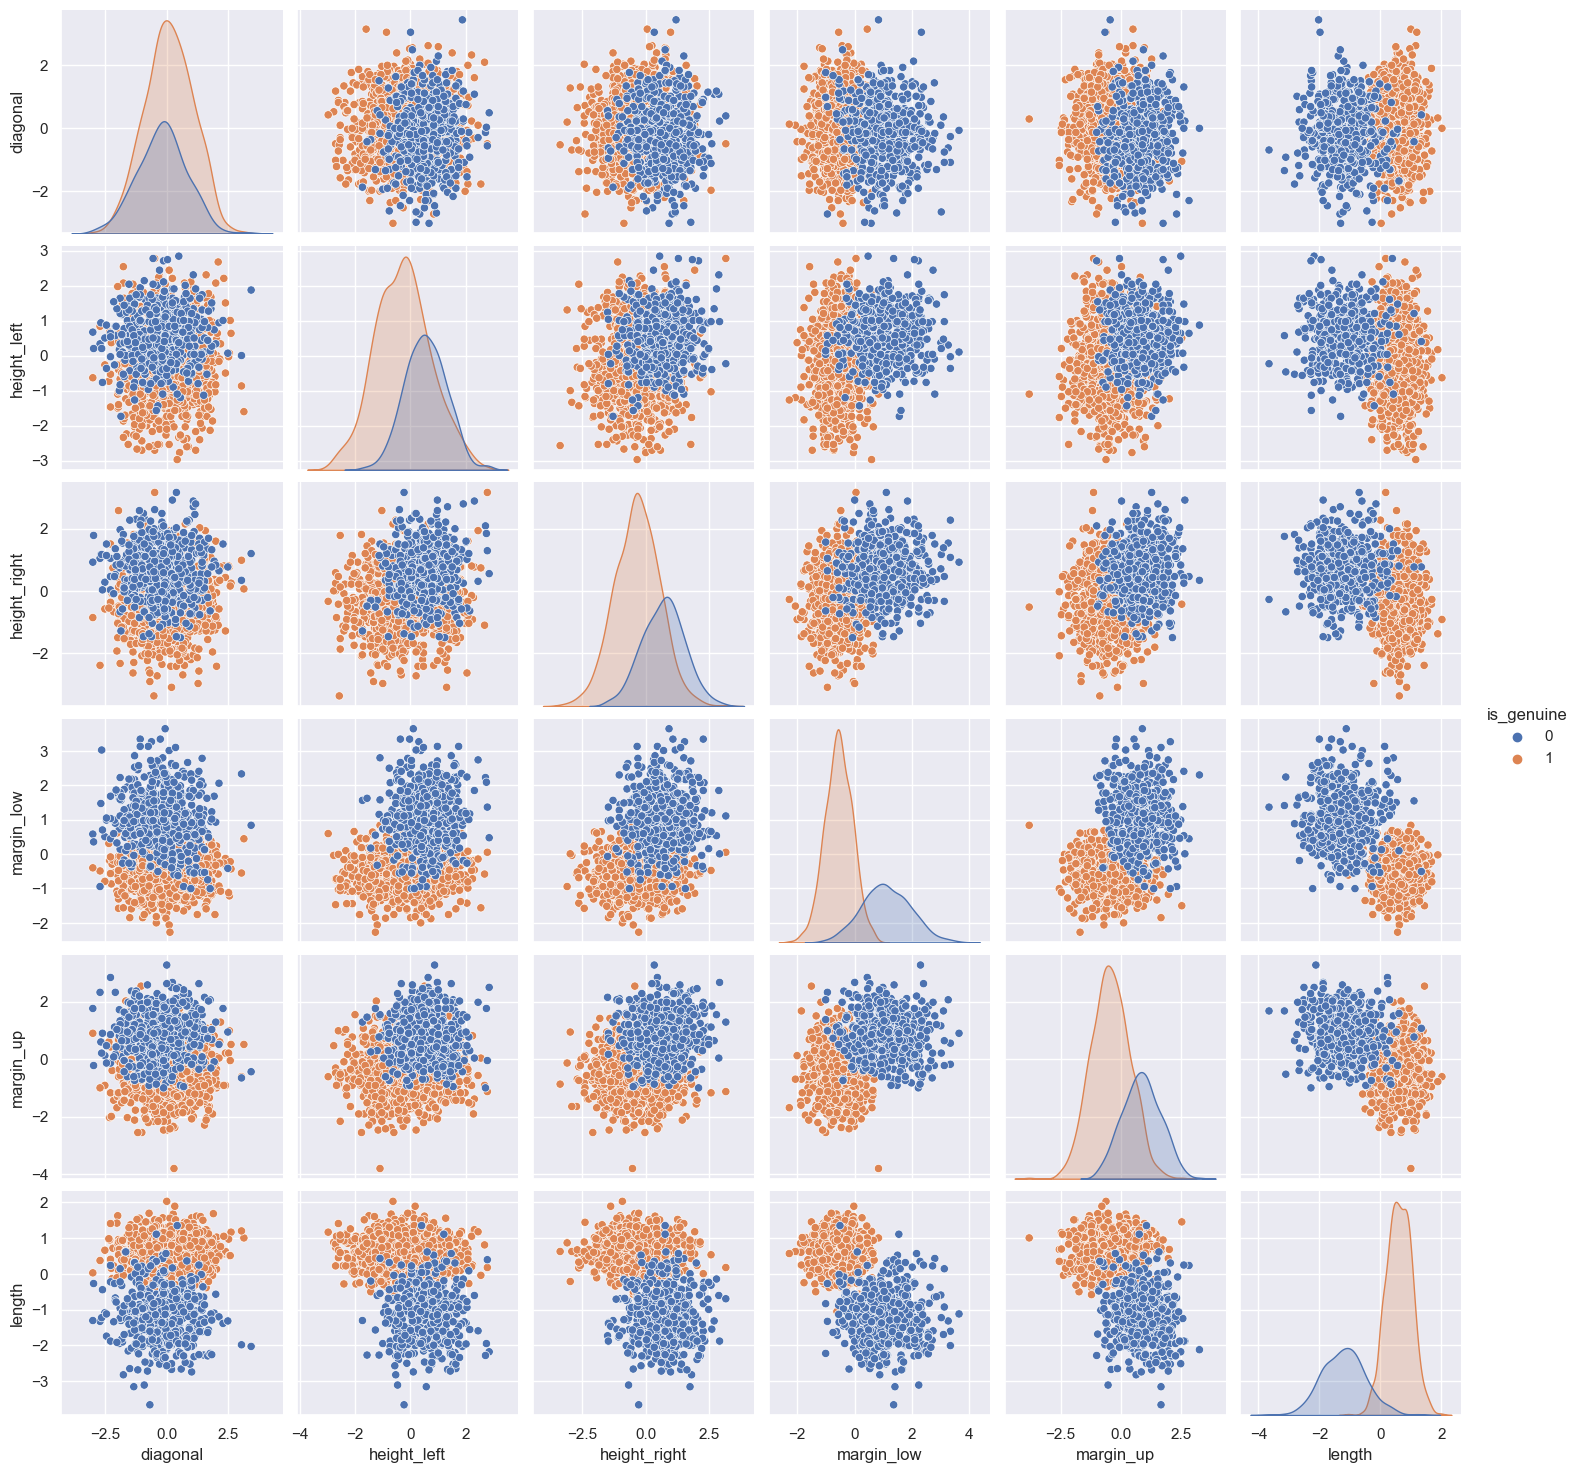

In [12]:
# Pairplot
sns.pairplot(data, hue="is_genuine")

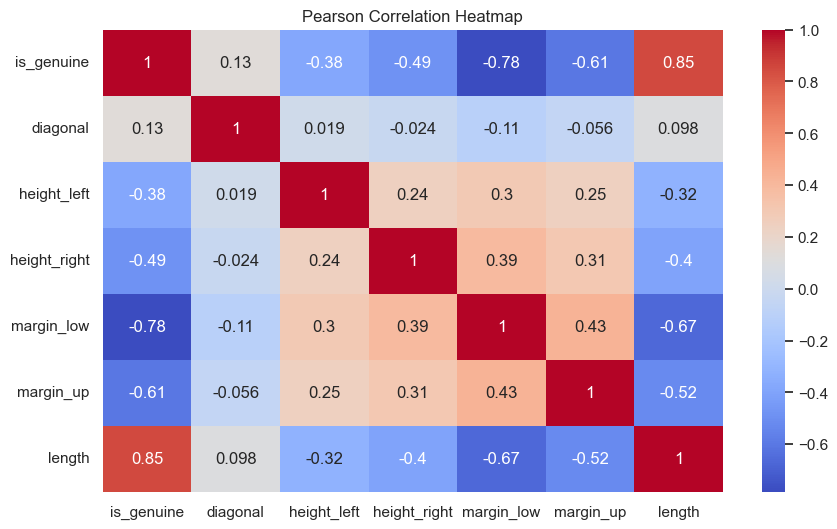

In [13]:
# Correlation heatmap
corr_heatmap(data)

In [14]:
# Multiple-factor ANOVA
anova_model = smf.ols("is_genuine ~ " + "+".join(cols_to_convert), data=data).fit()
print(anova_model.summary())

                            OLS Regression Results                            
Dep. Variable:             is_genuine   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1322.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        11:34:27   Log-Likelihood:                 384.34
No. Observations:                1463   AIC:                            -754.7
Df Residuals:                    1456   BIC:                            -717.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6655      0.005    136.475   

- We observe that some p-values are not less than 5%.
- None of the variables have an effect on "is_genuine", at least not a significant effect.

In [15]:
# Missing values
missing_values_proportion = banknotes.isna().mean()
print("Proportion of missing values:")
print(missing_values_proportion)

Proportion of missing values:
is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64


In [16]:
# Separate data with and without missing values in "margin_low"
banknotes_na = banknotes[banknotes["margin_low"].isna()]
banknotes_not_na = banknotes.dropna()

We want to be able to “predict” this data using linear regression.

### 2.1 Linear Regression

In [17]:
# Calculate correlation
correlation_margin_up_low = banknotes_not_na["margin_up"].corr(banknotes_not_na["margin_low"])
print("Correlation between margin_up and margin_low:", correlation_margin_up_low)

Correlation between margin_up and margin_low: 0.43160607332031437


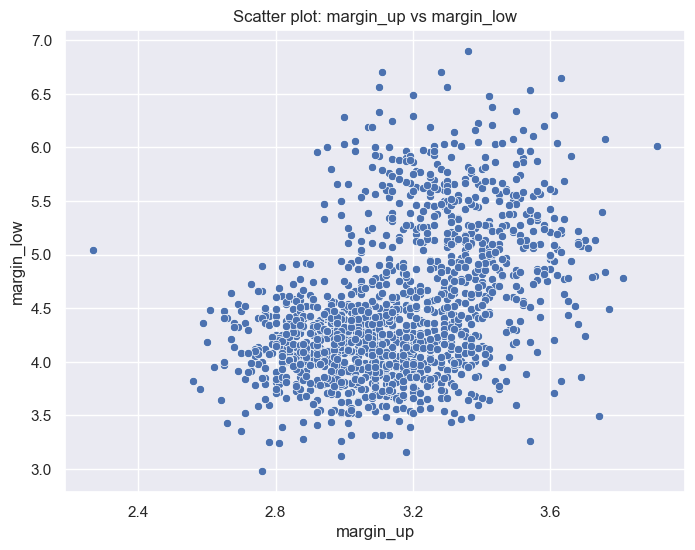

In [18]:
# Scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x="margin_up", y="margin_low", data=banknotes_not_na)
ax.set(xlabel='margin_up', ylabel='margin_low')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("Scatter plot: margin_up vs margin_low")
plt.show()

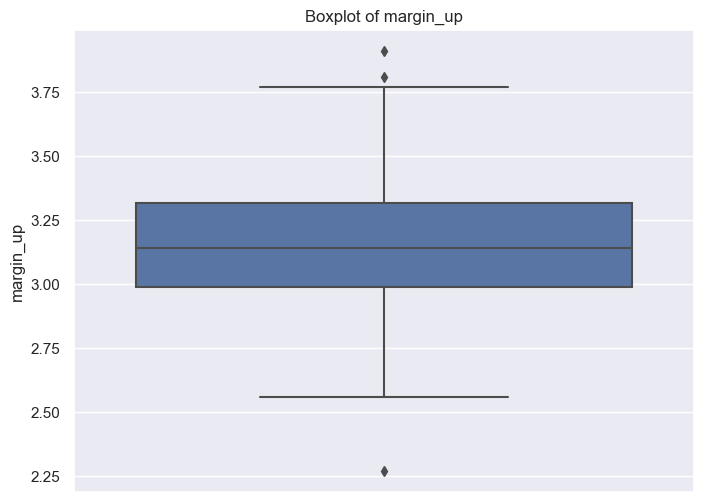

In [19]:
# Remove outliers in "margin_up"
plt.figure(figsize=(8, 6))
sns.boxplot(data=banknotes_not_na, y="margin_up")
plt.title("Boxplot of margin_up")
plt.show()

In [20]:
# Remove outliers
banknotes_not_na = banknotes_not_na[(banknotes_not_na["margin_up"] > 2.40) & (banknotes_not_na["margin_up"] < 3.75)]

In [21]:
# Fit linear regression
X = np.column_stack((np.ones(banknotes_not_na.shape[0]), banknotes_not_na["margin_up"]))
y = banknotes_not_na["margin_low"]
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print("Theta:", theta)

Theta: [0.52152779 1.25699074]


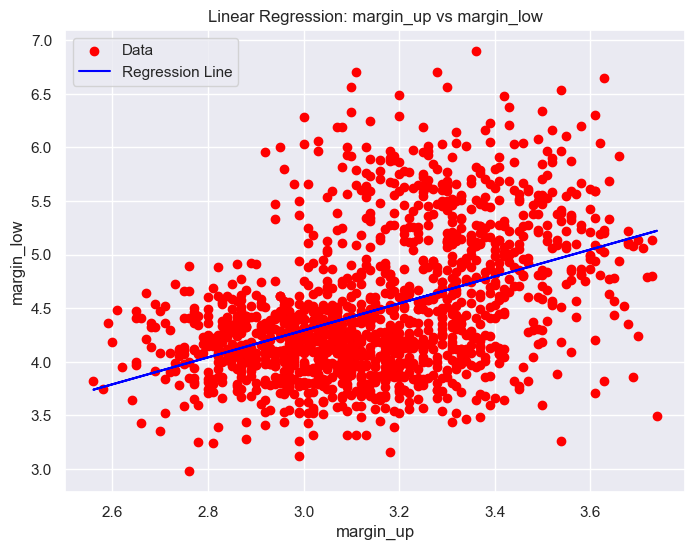

In [22]:
# Plot regression line
plt.figure(figsize=(8, 6))
plt.scatter(banknotes_not_na["margin_up"], banknotes_not_na["margin_low"], color='red', label='Data')
plt.plot(banknotes_not_na["margin_up"], X.dot(theta), color='blue', label='Regression Line')
plt.xlabel("margin_up")
plt.ylabel("margin_low")
plt.title("Linear Regression: margin_up vs margin_low")
plt.legend()
plt.show()

In [23]:
# Prediction for margin_low when margin_up is 4
predicted_margin_low = theta[0] + theta[1] * 4
print("Predicted margin_low for margin_up = 4:", predicted_margin_low)

Predicted margin_low for margin_up = 4: 5.549490760645704


**2.1.1 Simple Linear Regression**

In [24]:
# Fit simple linear regression
reg_simp = smf.ols("margin_low ~ margin_up", data=banknotes_not_na).fit()
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     332.0
Date:                Fri, 10 May 2024   Prob (F-statistic):           5.57e-67
Time:                        11:34:28   Log-Likelihood:                -1315.6
No. Observations:                1456   AIC:                             2635.
Df Residuals:                    1454   BIC:                             2646.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5215      0.218      2.393      0.0

- Some parameters have p-values greater than 5%
- R² is very low

In [25]:
# Add predicted values to the DataFrame
banknotes_not_na["margin_low_adjust_s"] = reg_simp.predict()

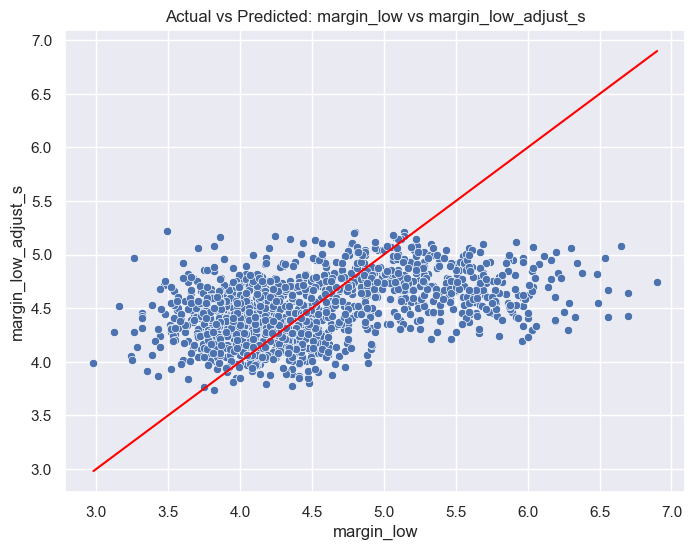

In [26]:
# Visualize simple linear regression
plt.figure(figsize=(8, 6))
sns.scatterplot(x="margin_low", y="margin_low_adjust_s", data=banknotes_not_na)
plt.xlabel("margin_low")
plt.ylabel("margin_low_adjust_s")
plt.title("Actual vs Predicted: margin_low vs margin_low_adjust_s")
plt.plot([banknotes_not_na["margin_low"].min(), banknotes_not_na["margin_low"].max()], [banknotes_not_na["margin_low"].min(), banknotes_not_na["margin_low"].max()], color="red")
plt.show()

**2.2.2 Backward Regression**

In [27]:
columns = ["margin_low", "diagonal", "is_genuine", "height_left", "height_right", "margin_up", "length"]
reg_backward = backward_selected(banknotes_not_na[columns], "margin_low")
print("Backward Regression Summary:")
print(reg_backward.summary())

--
margin_low ~ margin_up + height_right + diagonal + is_genuine + length + height_left + 1
Remove length (p-value: 0.766)

--
margin_low ~ margin_up + height_right + diagonal + is_genuine + height_left + 1
Remove diagonal (p-value: 0.611)

--
margin_low ~ margin_up + height_right + is_genuine + height_left + 1
Remove height_right (p-value: 0.411)

--
margin_low ~ margin_up + is_genuine + height_left + 1
Remove height_left (p-value: 0.379)

--
margin_low ~ margin_up + is_genuine + 1
Final model selected!

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1173.
Date:                Fri, 10 May 2024   Prob (F-statistic):          6.00e-304
Time:                        11:34:28   Log-Likelihood:                -765.65
No. Observation

- Some parameters are not significantly different from 0, as their p-value is not less than 5%
- R² is higher than before, but still low

In [28]:
# Train-test split
X = banknotes_not_na.drop(["margin_low", "margin_low_adjust_s", "diagonal", "height_left", "height_right", "length"], axis=1)
X = sm.add_constant(X, has_constant="add")
y = banknotes_not_na["margin_low"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
# Fit the model
model = sm.OLS(y_train, X_train)
result = model.fit()

In [30]:
# Model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     953.8
Date:                Fri, 10 May 2024   Prob (F-statistic):          9.24e-246
Time:                        11:34:28   Log-Likelihood:                -617.61
No. Observations:                1164   AIC:                             1241.
Df Residuals:                    1161   BIC:                             1256.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8400      0.227     25.689      0.0

**2.2.3 Assumptions Verification**

<Figure size 800x600 with 0 Axes>

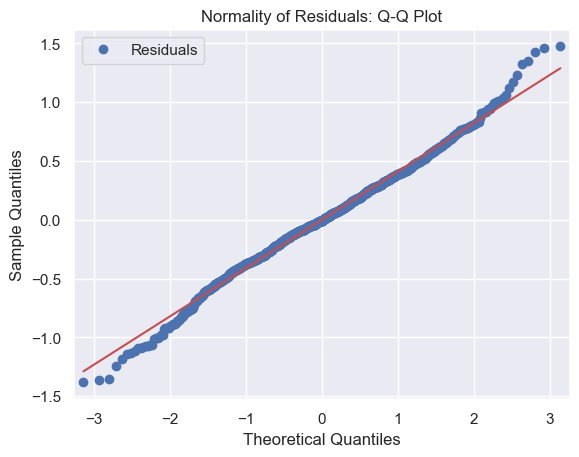

In [31]:
# Normality of residuals
residuals = result.resid
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line="s", label="Residuals")
plt.title("Normality of Residuals: Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.legend()
plt.show()

In [32]:
# Shapiro-Wilk test for normality
statistic, p_value = shapiro(residuals)
if p_value > 0.05:
    print("The residuals seem to follow a normal distribution (null hypothesis not rejected).")
else:
    print("The residuals do not follow a normal distribution (null hypothesis rejected).")
print("P-value:", round(p_value, 5))

The residuals do not follow a normal distribution (null hypothesis rejected).
P-value: 0.00011


In [33]:
# Homoscedasticity of residuals
groups = pd.qcut(result.fittedvalues, q=5, labels=False)
levene_test = levene(*[residuals[groups == i] for i in np.unique(groups)], center="mean")
test_statistic = levene_test.statistic
p_value = levene_test.pvalue
print("Levene Test Statistic:", round(test_statistic, 2))
print("P-value:", round(p_value, 5))
if p_value < 0.05:
    print("The assumption of homoscedasticity is violated.")
else:
    print("The assumption of homoscedasticity holds.")

Levene Test Statistic: 30.4
P-value: 0.0
The assumption of homoscedasticity is violated.


In [34]:
# Multicollinearity
vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("Variance Inflation Factor (VIF):")
print(round(vif, 4))

Variance Inflation Factor (VIF):
     Variable       VIF
0       const  354.6187
1  is_genuine    1.6097
2   margin_up    1.6097


- The normality of residuals is not verified.
- Homoscedasticity is not verified.
- Multicollinearity is verified.

Non-verification of normality and homoscedasticity may call into question the use of linear regression.

In [35]:
# Apply linear regression to fill missing values
X_missing = banknotes_na.drop(["margin_low", "height_right", "length", "diagonal", "height_left"], axis=1)
X_missing = sm.add_constant(X_missing)
y_missing = banknotes_na["margin_low"].values.reshape(-1, 1)
predicted_margin_low = result.predict(X_missing)
new_banknotes = banknotes_na.assign(margin_low=predicted_margin_low)

In [36]:
# Check if prediction worked by examining missing values proportion
print("\nProportion of missing values after prediction:")
print(new_banknotes.isna().mean())


Proportion of missing values after prediction:
is_genuine      0.0
diagonal        0.0
height_left     0.0
height_right    0.0
margin_low      0.0
margin_up       0.0
length          0.0
dtype: float64


In [37]:
# Check if the dimensionality of "margin_low" has changed after prediction
print("\nWith prediction:")
display(new_banknotes[["margin_low"]].describe())
print("\nWithout prediction:")
display(banknotes_not_na[["margin_low"]].describe())


With prediction:


margin_low
count   37.000000
mean     4.358883
std      0.471773
min      4.008842
25%      4.100395
50%      4.122367
75%      4.199271
max      5.303456


Without prediction:


margin_low
count  1456.000000
mean      4.482370
std       0.662179
min       2.980000
25%       4.010000
50%       4.310000
75%       4.870000
max       6.900000

In [38]:
# Concatenate the two datasets
data_combined = pd.concat([banknotes_not_na, new_banknotes])

In [39]:
# Drop unnecessary columns
data_combined = data_combined.drop(["margin_low_adjust_s"], axis=1)

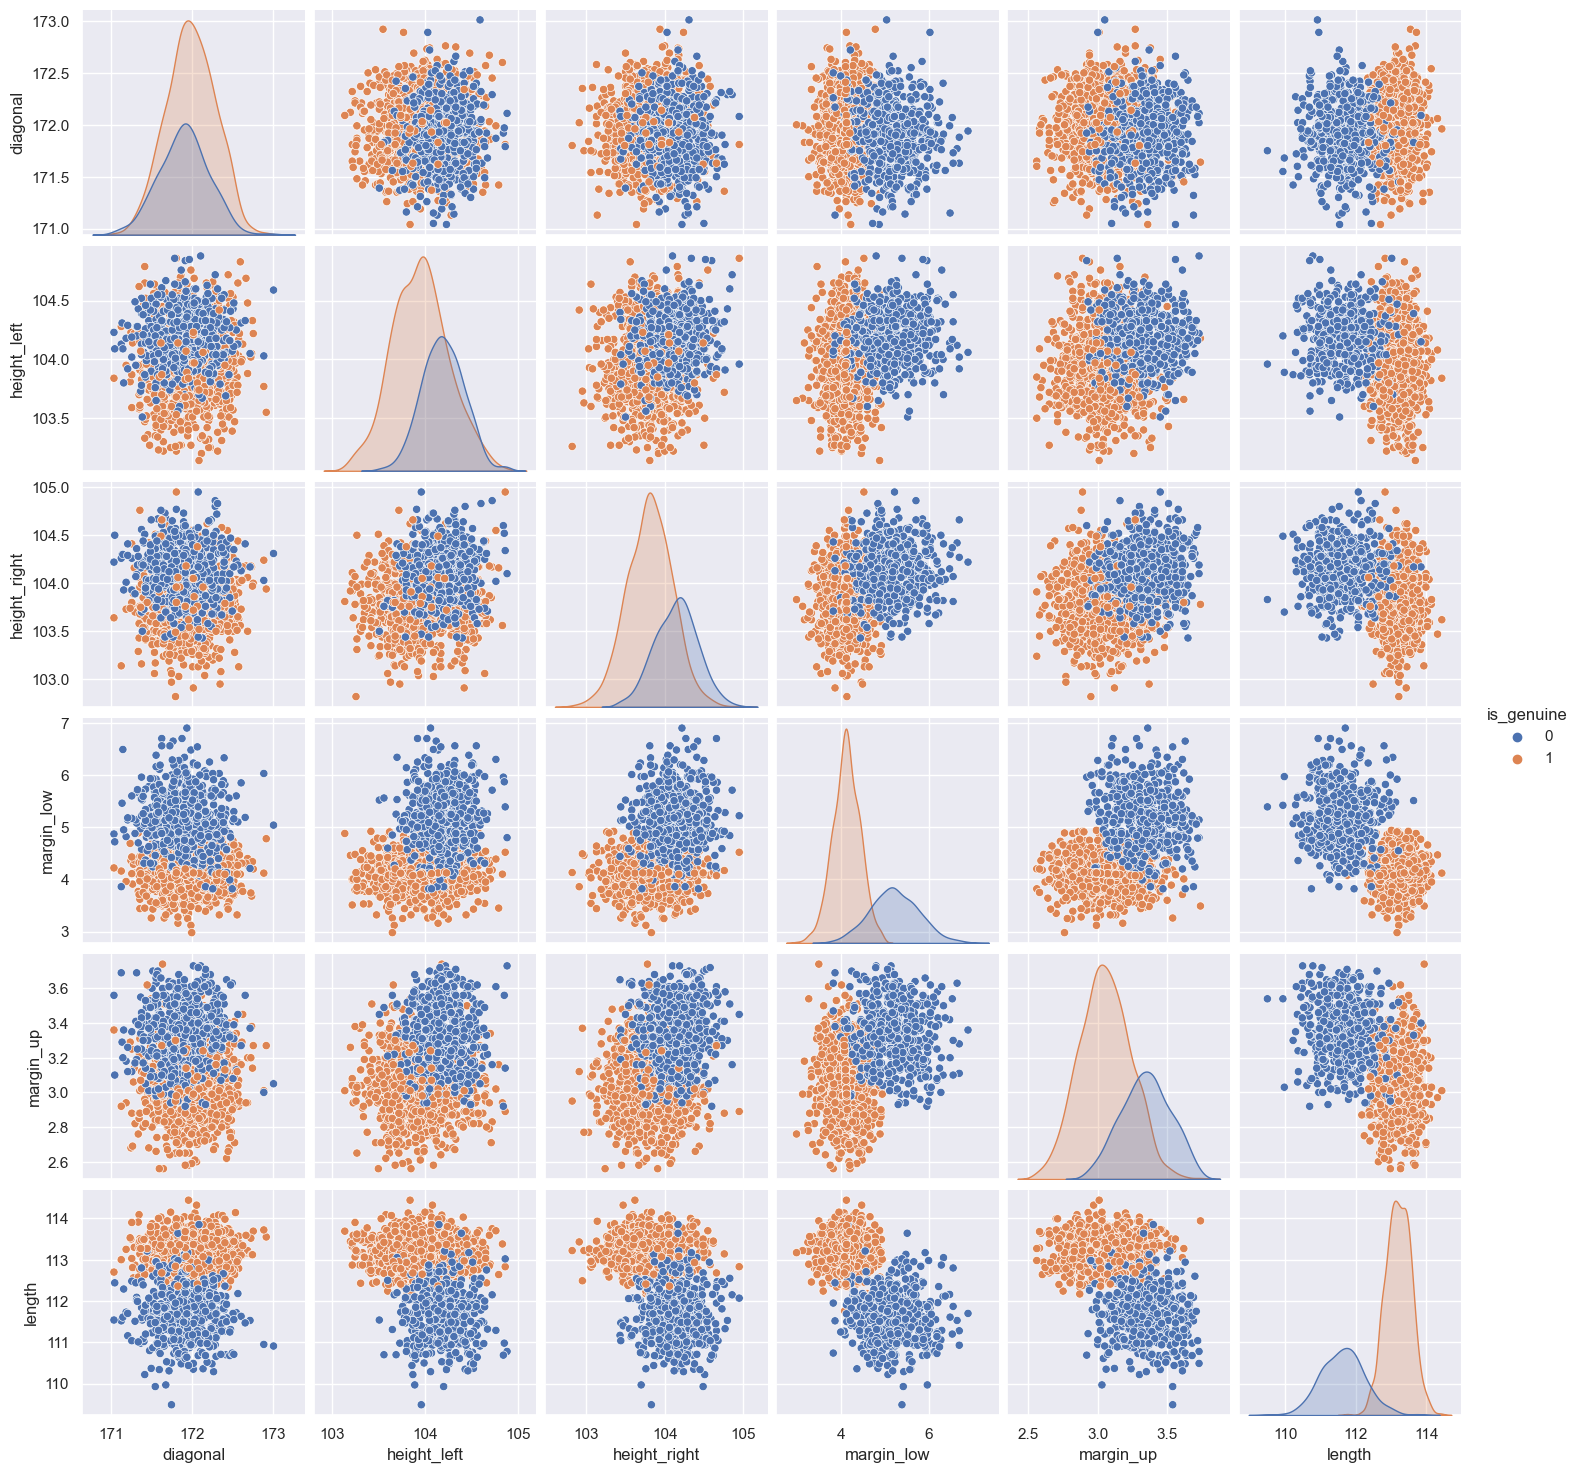

In [40]:
# Visualize the data
sns.pairplot(data_combined, hue="is_genuine")

In [41]:
# Describe the combined dataset
data_combined.describe()

is_genuine     diagonal  height_left  height_right   margin_low  \
count  1493.000000  1493.000000  1493.000000   1493.000000  1493.000000   
mean      0.669123   171.958687   104.029015    103.919169     4.479309   
std       0.470687     0.305121     0.299603      0.325170     0.658290   
min       0.000000   171.040000   103.140000    102.820000     2.980000   
25%       0.000000   171.750000   103.820000    103.700000     4.020000   
50%       1.000000   171.950000   104.040000    103.920000     4.300000   
75%       1.000000   172.170000   104.230000    104.150000     4.870000   
max       1.000000   173.010000   104.880000    104.950000     6.900000   

         margin_up       length  
count  1493.000000  1493.000000  
mean      3.149484   112.681802  
std       0.227586     0.870615  
min       2.560000   109.490000  
25%       2.990000   112.040000  
50%       3.140000   112.970000  
75%       3.310000   113.340000  
max       3.740000   114.440000

## 3. Banknote prediction

In [42]:
def time_execution(start_msg, end_msg):
    start_time = time.time()
    print(start_msg)
    return start_time, end_msg

In [43]:
# Splitting the dataset into training and testing sets
X = data_combined.drop("is_genuine", axis=1)
y = data_combined["is_genuine"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

### 3.1 k-NN<a class="anchor" id="sous_partie3-1"></a>

In [44]:
start_time, end_msg = time_execution("Starting k-NN training...", "k-NN training completed.")

Starting k-NN training...


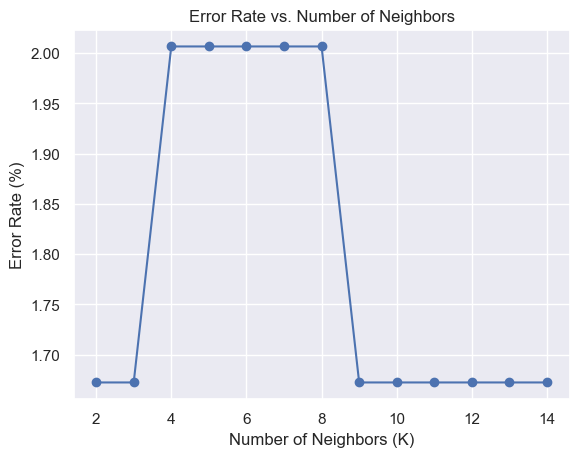

In [45]:
errors = []
for k in range(2, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    errors.append(100 * (1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2, 15), errors, 'o-')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Error Rate (%)")
plt.title("Error Rate vs. Number of Neighbors")
plt.show()

In [46]:
# GridSearchCV for k-NN
param_grid = {
    "n_neighbors": np.arange(1, 50),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best score with training data:", round(grid_search.best_score_ * 100, 4), "%")
print("Best parameters:", grid_search.best_params_)
knn_model = grid_search.best_estimator_
joblib.dump(knn_model, "knn_model.joblib")
print("Time taken for k-NN GridSearchCV:", round(time.time() - start_time, 2), "seconds")

Best score with training data: 99.3302 %
Best parameters: {'algorithm': 'auto', 'n_neighbors': 12, 'weights': 'uniform'}
Time taken for k-NN GridSearchCV: 10.86 seconds


In [47]:
# Prediction and evaluation for k-NN
y_pred = knn_model.predict(X_test)
f1_knn = f1_score(y_test, y_pred)
print("The F1-score on the test data for k-NN is:", round(f1_knn * 100, 4), "%")

The F1-score on the test data for k-NN is: 98.7715 %


#### 3.1.1 Confusion Matrix

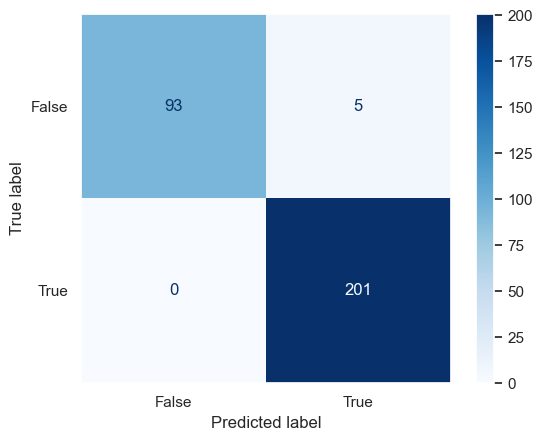

In [48]:
plot_confusion_matrix(y_test, y_pred, ["False", "True"])

- We have 93 true negatives
- We have 0 false negatives
- We have 5 false positives
- We have 201 true positives

In [49]:
time_knn = round(time.time() - start_time, 2)
print(f"Time taken for k-NN: {time_knn} seconds")

Time taken for k-NN: 10.98 seconds


#### 3.1.2 Validation Curve

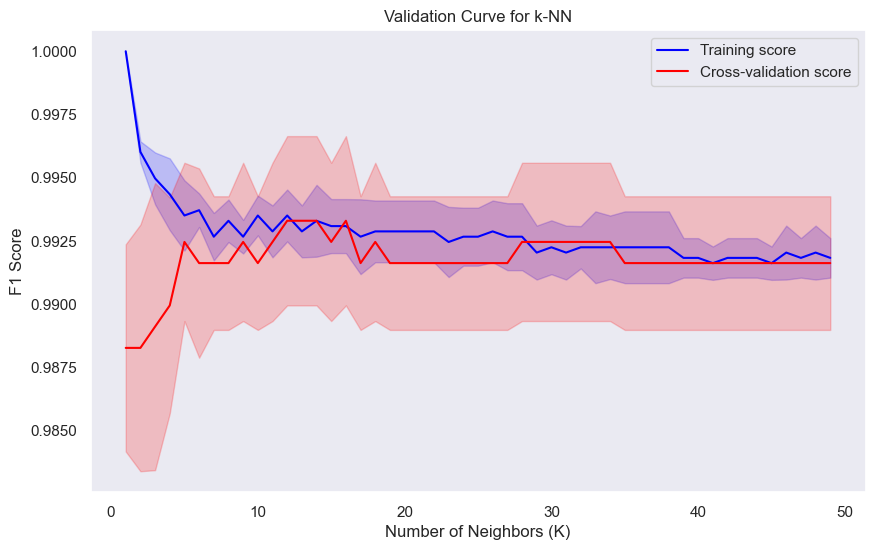

In [50]:
param_range = np.arange(1, 50)
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", param_range=param_range, cv=5, scoring="accuracy")
plot_validation_curve(param_range, train_scores, test_scores, "Number of Neighbors (K)", "Validation Curve for k-NN")

#### 3.1.3 Learning Curve

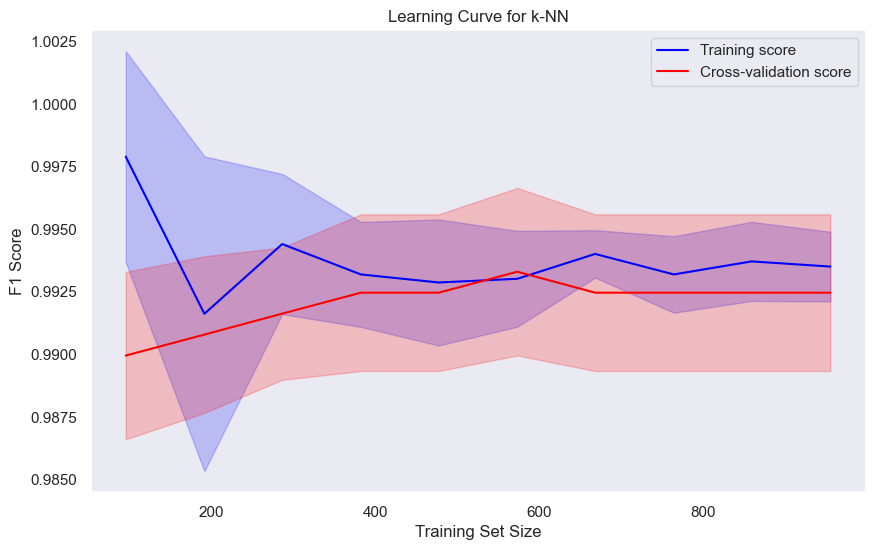

In [51]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(n_neighbors=5), X_train, y_train, train_sizes=train_sizes, cv=5, scoring="accuracy")
plot_learning_curve(train_sizes, train_scores, test_scores, "Learning Curve for k-NN")

### 3.2 K-Means<a class="anchor" id="sous_partie3-2"></a>

In [52]:
start_time, end_msg = time_execution("Starting K-Means training...", "K-Means training completed.")

Starting K-Means training...


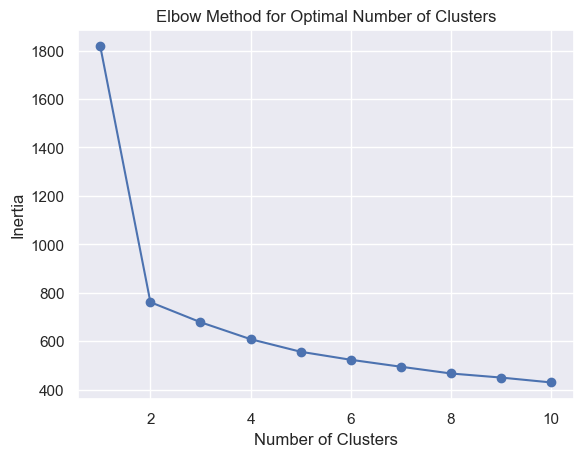

Optimal number of clusters: 2


In [53]:
# Finding the optimal number of clusters using the elbow method
n_clusters = kmeans_elbow(X_train, cluster_max=10)

In [54]:
# Initializing and training the K-Means model with the optimal number of clusters
kmeans_model = KMeans(n_clusters=n_clusters)
kmeans_model.fit(X_train)

KMeans(n_clusters=2)

In [55]:
# Making predictions
predictions_kmeans = kmeans_model.predict(X_test)

In [56]:
# Assigning predicted clusters to the test data
X_test["cluster"] = predictions_kmeans

In [57]:
# Calculating the F1 score
f1_kmeans = f1_score(y_test, X_test["cluster"])

In [58]:
# Adjusting the F1 score if needed
if f1_kmeans < 0.5:
    X_test["cluster"].replace({0: 1, 1: 0}, inplace=True)
    f1_kmeans = f1_score(y_test, X_test["cluster"])

# Printing the F1 score
print("The F1-score on the test data is:", round(f1_kmeans * 100, 4), "%")

The F1-score on the test data is: 97.5728 %


In [59]:
# Saving the trained K-Means model
joblib.dump(kmeans_model, "kmeans_model.joblib")

['kmeans_model.joblib']

#### 3.2.1 Confusion Matrix

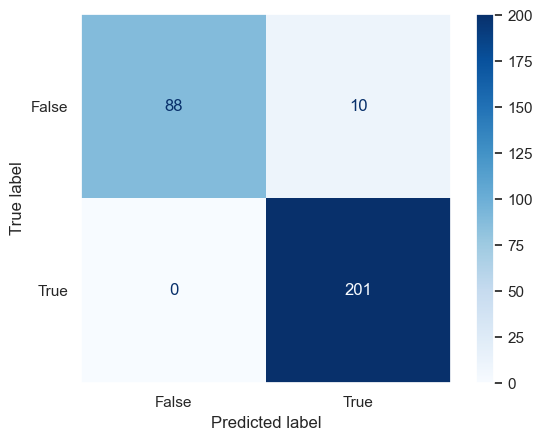

In [60]:
plot_confusion_matrix(y_test, X_test.cluster, ["False", "True"])

- We have 88 true negatives
- We have 0 false negatives
- We have 10 false positives 
- We have 201 true positives

We have more false positives than with k-NN.

In [61]:
time_kmeans = round(time.time() - start_time, 2)
print(f"Time taken for K-Means: {time_kmeans} seconds")

Time taken for K-Means: 0.79 seconds


#### 3.2.2 Validation Curve

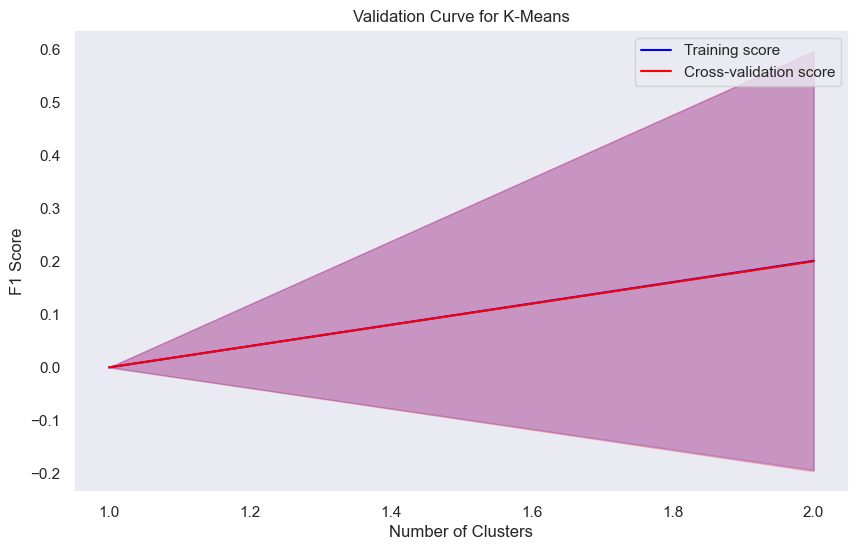

In [62]:
param_range_kmeans = np.arange(1, 11)
train_scores_kmeans, test_scores_kmeans = validation_curve(
    KMeans(), X_train, y_train, param_name="n_clusters", param_range=param_range_kmeans,
    cv=5, scoring="f1", n_jobs=-1)
plot_validation_curve(param_range_kmeans, train_scores_kmeans, test_scores_kmeans, "Number of Clusters", "Validation Curve for K-Means")

#### 3.2.3 Learning Curve

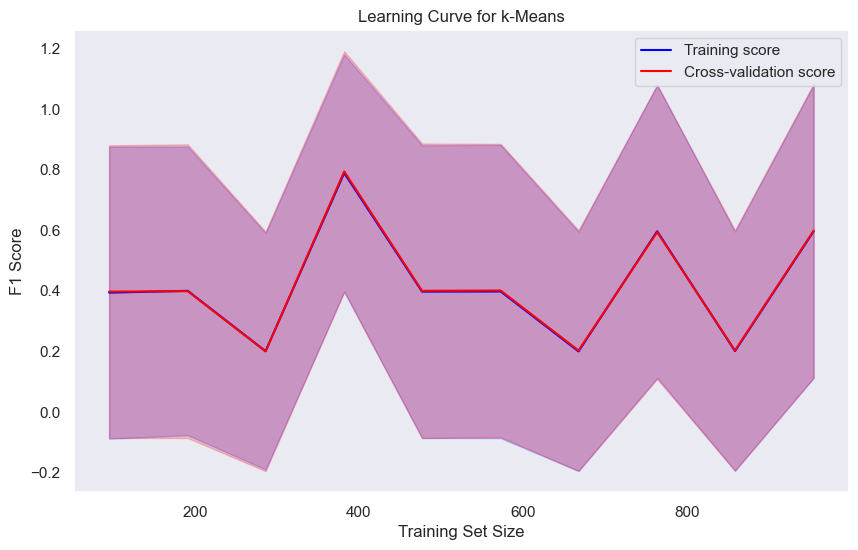

In [63]:
train_sizes_kmeans = np.linspace(0.1, 1.0, 10)
train_sizes_kmeans, train_scores_kmeans, test_scores_kmeans = learning_curve(
    KMeans(n_clusters=kmeans_model.n_clusters), X_train, y_train,
    train_sizes=train_sizes_kmeans, cv=5, scoring="f1", n_jobs=-1)
plot_learning_curve(train_sizes_kmeans, train_scores_kmeans, test_scores_kmeans, "Learning Curve for k-Means")

### 3.3 Logistic Regression

In [64]:
start_time, end_msg = time_execution("Starting Logistic Regression training...", "Logistic Regression training completed.")

Starting Logistic Regression training...


In [65]:
# Perform backward selection for logistic regression
reg_backward = backward_selected_logistic(data_combined[columns], "is_genuine")

--
is_genuine ~ margin_up + height_right + diagonal + length + height_left + margin_low + 1
Optimization terminated successfully.
         Current function value: 0.026449
         Iterations 13
Remove diagonal (p-value: 0.816 )

--
is_genuine ~ margin_up + height_right + length + height_left + margin_low + 1
Optimization terminated successfully.
         Current function value: 0.026467
         Iterations 13
Remove height_left (p-value: 0.253 )

--
is_genuine ~ margin_up + height_right + length + margin_low + 1
Optimization terminated successfully.
         Current function value: 0.026910
         Iterations 13
Final model selected!

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1493
Model:                          Logit   Df Residuals:                     1488
Method:                           MLE   Df Model:                            4
Date:                Fri, 10 May 2024  

In [66]:
# Extract necessary data by removing insignificant descriptive variables
X = data_combined.drop(["is_genuine", "diagonal", "height_left"], axis=1)
y = data_combined["is_genuine"]

In [67]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [68]:
# Define and train logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [69]:
# Make predictions
y_pred = logistic_reg.predict(X_test)

In [70]:
# Evaluate model
f1_reg = f1_score(y_test, y_pred)
print("The F1-score on the test data is:", round(f1_reg * 100, 4), "%")

The F1-score on the test data is: 98.7715 %


In [71]:
# Print classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9490    0.9738        98
           1     0.9757    1.0000    0.9877       201

    accuracy                         0.9833       299
   macro avg     0.9879    0.9745    0.9808       299
weighted avg     0.9837    0.9833    0.9832       299



In [72]:
# Save the trained logistic regression model
joblib.dump(logistic_reg, "logistic_reg_model.joblib")

['logistic_reg_model.joblib']

#### 3.3.1 Matrice de confusion

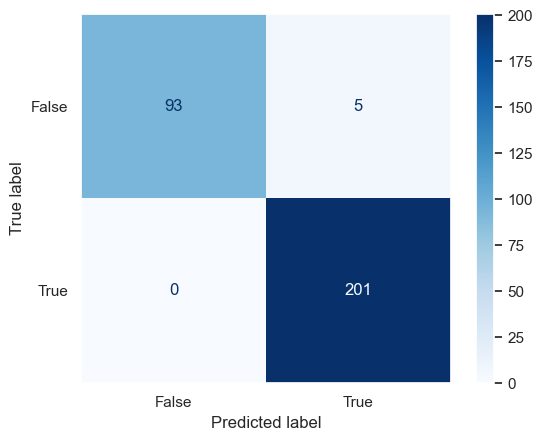

In [73]:
plot_confusion_matrix(y_test, y_pred, ["False", "True"])

- We have 93 true negatives
- We have 0 false negatives
- We have 5 false positives
- We have 201 true positives

The matrix is the same as with k-NN.

In [74]:
time_reg = round(time.time() - start_time, 2)
print(f"Time taken for Logistic Regression: {time_reg} seconds")

Time taken for Logistic Regression: 0.29 seconds


#### 3.3.2 Validation Curve

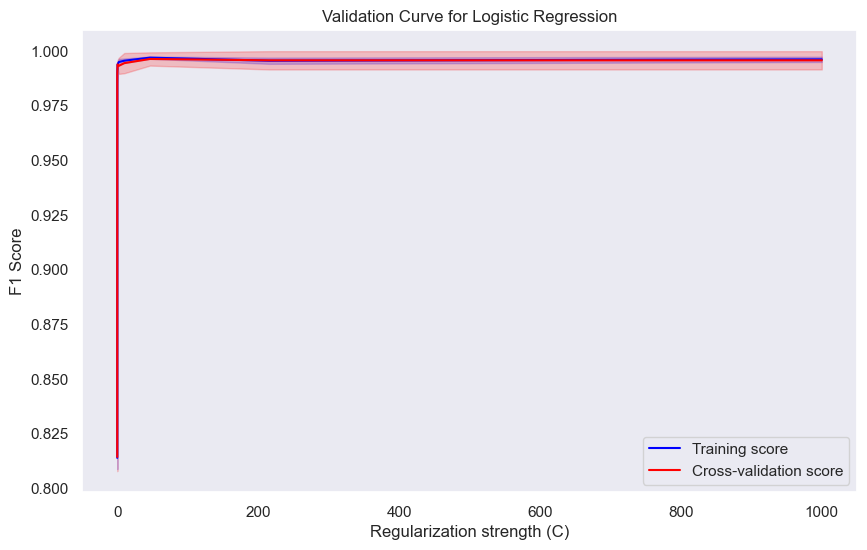

In [75]:
param_range_reg = np.logspace(-3, 3, 10)
train_scores_reg, test_scores_reg = validation_curve(
    LogisticRegression(), X_train, y_train, param_name="C", 
    param_range=param_range_reg,
    cv=5, scoring="f1", n_jobs=-1)
plot_validation_curve(param_range_reg, train_scores_reg, test_scores_reg, "Regularization strength (C)", "Validation Curve for Logistic Regression")

#### 3.3.3 Learning Curve

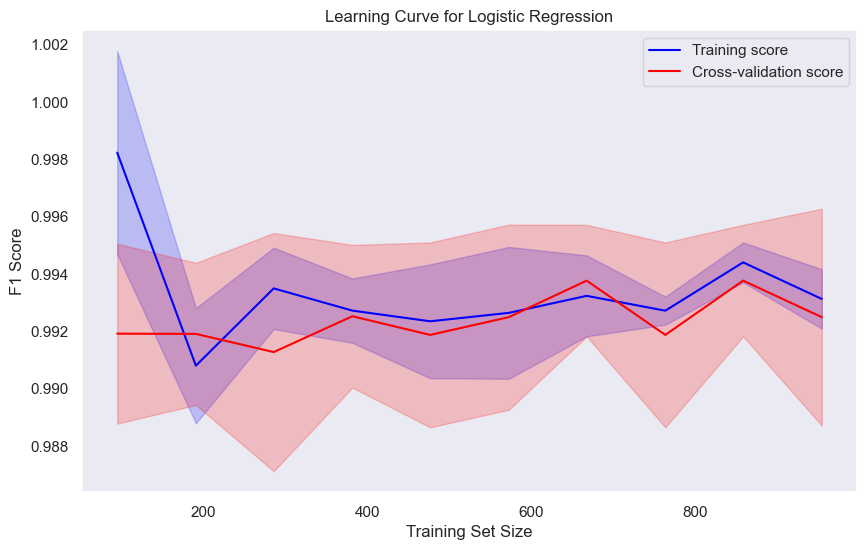

In [76]:
train_sizes_reg = np.linspace(0.1, 1.0, 10)
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
    LogisticRegression(), X_train, y_train, train_sizes=train_sizes_reg,
    cv=5, scoring="f1", n_jobs=-1)
plot_learning_curve(train_sizes, train_scores_reg, test_scores_reg, "Learning Curve for Logistic Regression")

### 3.4 XGBoost

In [77]:
start_time, end_msg = time_execution("Starting XGBoost training...", "XGBoost training completed.")

Starting XGBoost training...


In [78]:
# Define and train xgboost model
xgboost = XGBClassifier()
xgboost = xgboost.fit(X_train, y_train)

In [79]:
# Make predictions
y_pred = xgboost.predict(X_test)

In [80]:
# Round the predictions to 0 or 1
predictions = [round(value) for value in y_pred]

In [81]:
# Calculate F1 score
f1_xgb = f1_score(y_test, predictions)

# Print F1 score
print("The F1-score on the test data is:", round(f1_xgb * 100, 4), "%")

The F1-score on the test data is: 98.5149 %


In [82]:
# Save the trained xgboost model
joblib.dump(xgboost, "xgboost_model.joblib")

['xgboost_model.joblib']

#### 3.4.1 Matrice de confusion

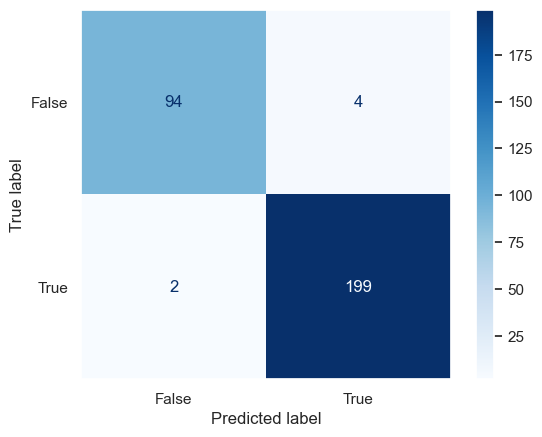

In [83]:
plot_confusion_matrix(y_test, predictions, ["False", "True"])

- We have 94 true negatives
- We have 2 false negatives
- We have 4 false positives
- We have 199 true positives

The matrix is not as good as previous algorithms.

In [84]:
time_xgb = round(time.time() - start_time, 2)
print(f"Time taken for XGBoost: {time_xgb} seconds")

Time taken for XGBoost: 0.22 seconds


#### 3.4.2 Validation Curve

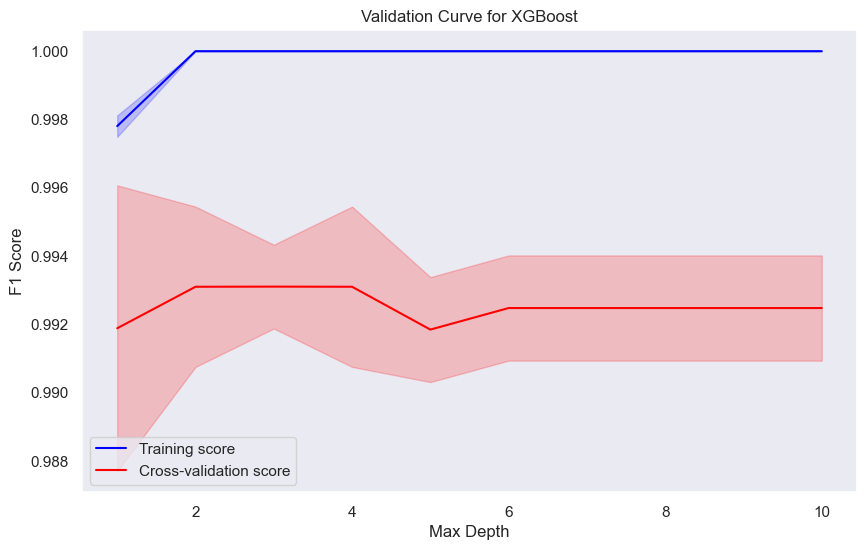

In [85]:
param_range_xgb = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores_xgb, test_scores_xgb = validation_curve(
    XGBClassifier(), X_train, y_train, param_name="max_depth", param_range=param_range_xgb,
    cv=5, scoring="f1", n_jobs=-1)
plot_validation_curve(param_range_xgb, train_scores_xgb, test_scores_xgb, "Max Depth", "Validation Curve for XGBoost")

#### 3.4.3 Learning Curve

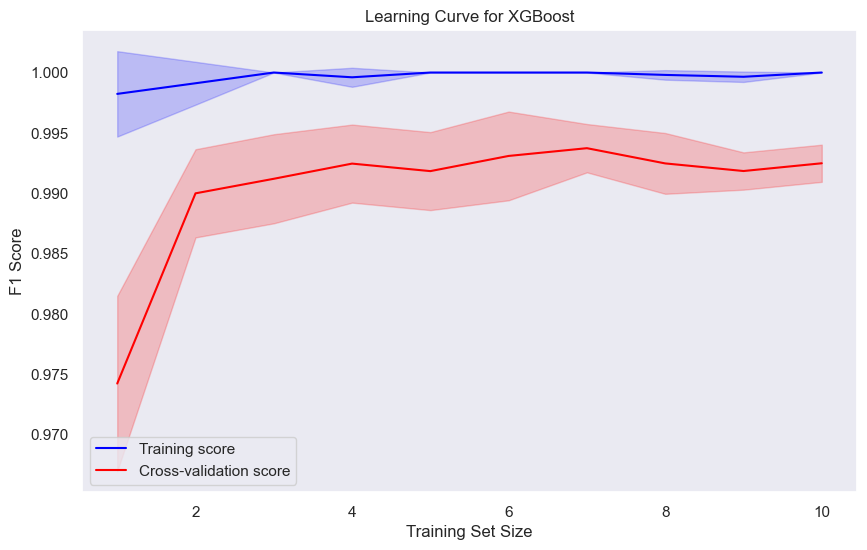

In [86]:
param_range_xgb = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_sizes_xgb, train_scores_xgb, test_scores_xgb = learning_curve(
    XGBClassifier(), X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring="f1", n_jobs=-1)
plot_learning_curve(param_range_xgb, train_scores_xgb, test_scores_xgb, "Learning Curve for XGBoost")

## 4. Model Selection

In [87]:
model_data = {
    "Model": ["k-NN", "K-Means", "Logistic Regression", "XGBoost"],
    "F1 Score": [f1_knn, f1_kmeans, f1_reg, f1_xgb],
    "Time (seconds)": [time_knn, time_kmeans, time_reg, time_xgb]
}

model_scores = pd.DataFrame(model_data)
model_scores.set_index("Model", inplace=True)

In [88]:
display(model_scores)

F1 Score  Time (seconds)
Model                                        
k-NN                 0.987715           10.98
K-Means              0.975728            0.79
Logistic Regression  0.987715            0.29
XGBoost              0.985149            0.22

- Based on F1 scores, we exclude K-Means and XGBoost from our choice.
- Only the execution time of the algorithms differentiates k-NN from  the Logistic Regression.